# Stratifying COVID-19 Patients Based on Clinical Characteristics 
## Code used in Applied Concept Paper # 1
* This notebook includes all the code used to develop the dataset, prepare the data, and create the visualizations.


## Set up libraries etc

In [673]:
import os
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

## Read your credentials for accessing the COVID database from a file
* In general, personal credentials should never be included in a code file that you will share

In [436]:
"""with open("credentials.txt") as cred_file:
    myUserName = cred_file.readline().strip()
    myPassword = cred_file.readline().strip()
# print(myUserName)
# print(myPassword)

"""
myUserName = 'ashv'
myPassword = 'l1Zs6d9QwTBKlAgQKY6pjx0u'



## Set up the database connection using sqlalchemy

In [540]:
server_url = "chip690-primary"
database = "omop_covid"

# Create Connection String
conn_str = f"{myUserName}:{myPassword}@{server_url}/{database}"

# Create Engine
engine = sqlalchemy.create_engine('postgresql://' + conn_str)

## Below is the query provided by Emily that reads the data

In [374]:
query = '''

--find COVID-19 lab test concepts (only one in this database)
WITH lab_test_concepts as (
SELECT *
FROM concept
WHERE concept_code IN ('94531-1') AND vocabulary_id = 'LOINC'),
 
--find standard COVID-19 dx code
standard_dx as (
SELECT distinct concept_id_2
FROM concept c JOIN concept_relationship cr ON c.concept_id = cr.concept_id_1
WHERE c.concept_code = 'U07.1' AND cr.relationship_id = 'Maps to'  
),
 
--find patients with COVID using the diagnosis code
covid_dx_pts as (
SELECT distinct co.person_id, co.condition_start_date
FROM condition_occurrence co JOIN standard_dx sd ON co.condition_concept_id =
      sd.concept_id_2
),
 
--find patients with COVID using the lab test
covid_lab_pts as (
SELECT m.person_id, m.measurement_date
FROM measurement m JOIN lab_test_concepts lt ON m.measurement_concept_id = lt.concept_id
WHERE m.value_source_value = 'Detected (qualifier value)'
),
 
--union the lab and diagnosis cohorts
all_patients as (
select person_id, measurement_date as cov_dt from covid_lab_pts
      UNION
select person_id, condition_start_date as cov_dt from covid_dx_pts
),
 
 
--find all patients hospitalized in the correct date range
hospitalized as (
SELECT vo.person_id, visit_occurrence_id, ap.cov_dt, vo.visit_start_date, vo.visit_end_date
FROM visit_occurrence vo JOIN all_patients ap ON vo.person_id = ap.person_id
      AND vo.visit_start_date - ap.cov_dt between -7 and 14
      AND vo.visit_concept_id = 9201
),
 
--find patients with ECMO or ventilator during their hospitalization
ecmo_vent as (
select distinct po.person_id, h.cov_dt
from procedure_occurrence po JOIN hospitalized h ON po.visit_occurrence_id = h.visit_occurrence_id
where po.procedure_concept_id IN (4337616,2893766,4082243,45889042,4140765,4219858,4303945,
                                       4337615,4337617,4337045,44515633,4013354,4287922,4235361,
                                          45887795,2805870,4174085,4283807,2813710,4325601,4134538,
                                          4339623,4353715,4335584,4179373,4251737,4335481,2314000,
                                          4072633,2800859,4149878,40487536,42738852,4335583,4031379,
                                          765576,44791135,4308797,4259233,37116698,2788037,44808555,
                                          4335585,4232891,2007912,2834015,44509482,2788018,4056812,
                                          2106469,4080957,2867784,2788038,4301549,4134853,4119642,
                                          4168966,4230167,4237618,2788023,46273390,2314001,2788028,
                                          40481547,4058031,4287921,2788036,4026054,2108681,42738853,
                                          4229714,37116689,46257680,46257586,46257469,46257399,46257682,
                                          46257440,4338595,46257398,46257585,46257511,46257438,2002247,
                                          46257683,46257730,46257439,46257397,46257685,37206603,46257513,
                                          46257684,46257400,1531630,2787821,46257441,46257468,46257512,
                                          44811012,37206602,46257510,46257544,37206601,46257729,2787820,
                                          1531631,4052536,46257467,44515635,1531632,46257543,46257466)
),
 
vasopress as (
select distinct de.person_id, h.cov_dt
from drug_exposure de JOIN hospitalized h ON de.visit_occurrence_id = h.visit_occurrence_id
where drug_concept_id IN (40072394,46287545,42628989,19076659,964320,1368671,42902898,1593970,
                                   1593980,42799670,19136059,42628991,42628988,1321364,19111072,963889,
                                   42903217,35606572,35202043,35758740,46275915,1337750,740268,42799674,
                                   1321341,44032830,740269,40240695,42628990,42799685,1593981,42628995,
                                   42902848,35606562,1719037,19056879,964327,35606567,35606561,1343916,
                                   35606568,1719038,1321363,19091005,46287575,1719039,46287547,35606570,
                                   40074086,35606563,42628993,40071162,19076658,37499754,45775841,
                                   35606558,35606565,35201925,740243,1507838,740244,42628996,35606564,
                                   964321,42707287,1593969,1135766,40865800,1344055,35606569,35782395,
                                   35606566,42707286,42799684,1593464,45776267,1337860,35201924,1593459,
                                   19020994,1337720,35202042,1507835,19079625,35606571,19058101,40087301,
                                   19076660,1344052,40929934,19079028,1594056,46287544,42799044,19039813,
                                   36885592,964326,35603731,40038600,35867254,40035704,19036210,1361711,
                                   46287548,19040856,19101883,1593971,41252710,42628994,1362232)
),
 
--union the ecmo, vent, and vasopressor patients in a single table
all_severe as (
select person_id, cov_dt, 'severe' as category from ecmo_vent
      UNION
select person_id, cov_dt, 'severe' as category from vasopress
),
 
--grab patients who were hospitalized but not severe for moderate category
all_mod as (
select h.person_id, h.cov_dt, 'moderate' as category
from hospitalized h LEFT JOIN all_severe asv ON h.person_id = asv.person_id
where asv.person_id is null
),
 
--grab everyone with covid but not hospitalized
all_mild as (
select ap.person_id, ap.cov_dt, 'mild' as category
from all_patients ap LEFT JOIN hospitalized h ON ap.person_id = h.person_id
WHERE h.person_id is null
),
 
--flag every patient with their severity category
patients_w_sev as (
select * from all_severe UNION select * from all_mod UNION select * from all_mild
),
 
--add demographic information for each patient
patients_w_demos as (
select ps.*, racecon.concept_name as race_name, gencon.concept_name as gen_name,
      floor(extract(day from (current_date - p.birth_datetime))/365.25) as current_age
from person p JOIN concept racecon ON p.race_concept_id = racecon.concept_id
      JOIN concept gencon ON p.gender_concept_id = gencon.concept_id
      JOIN patients_w_sev ps ON p.person_id = ps.person_id
),
 
--pull all numeric lab values for all patients between 0 and 14 days from their covid diagnosis date
all_meas as (
select pw.*, con.concept_name as measurement_name, m.measurement_date, m.value_as_number,
      unit.concept_name as unit_name
from measurement m JOIN concept con ON m.measurement_concept_id = con.concept_id
      JOIN concept unit ON m.unit_concept_id = unit.concept_id
      JOIN patients_w_demos pw ON pw.person_id = m.person_id
WHERE (m.measurement_date - pw.cov_dt) between 0 and 14 and m.value_as_number is not null),
 
--find the most common labs
toplabs as (
select measurement_name, count(*) as meascount
from all_meas
group by measurement_name
order by meascount desc
),
 
final_tbl as (
--limit result set to the most common labs
select a.*
from all_meas a JOIN toplabs t ON a.measurement_name = t.measurement_name and t.meascount >= 214000
),
 
people_only as (
select distinct person_id, category
from final_tbl),
 
people_union as (
select distinct person_id, category, floor(random() * 6000 + 1)::int as rannum
from people_only
where category = 'severe'
 
UNION
 
select distinct person_id, category, floor(random() * 12000 + 1)::int as rannum
from people_only
where category = 'moderate'
 
UNION
 
select distinct person_id, category, floor(random() * 100000 + 1)::int as rannum
from people_only
where category = 'mild'
)
 
select f.*
from people_union p JOIN final_tbl f ON p.person_id = f.person_id
where (p.category = 'severe' AND rannum <= 450)
     OR (p.category = 'moderate' AND rannum <= 400)
     OR (p.category = 'mild' AND rannum <= 1500)

'''

## Read the data

In [674]:
person_data = pd.read_sql_query(query, engine)
person_data

KeyboardInterrupt: 

## Write the data to a CSV file

In [675]:
person_data.to_csv("data_covid.csv", index = False)

## Once you have your random selection of data saved, do not run the data retrieval query again, rather read teh CSV file taht yo have saved

In [627]:
person_data = pd.read_csv("data_covid.csv")
person_data

,person_id,cov_dt,category,Race,Sex,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,Age Groups
0,5,2020-03-10,mild,White,FEMALE,35.0,Body temperature,2020-03-10,41.6,degree Celsius,18-45,18-45
1,5,2020-03-10,mild,White,FEMALE,35.0,Respiratory rate,2020-03-10,14.4,per minute,18-45,18-45
2,5,2020-03-10,mild,White,FEMALE,35.0,Oxygen saturation in Arterial blood,2020-03-10,88.4,percent,18-45,18-45
3,5,2020-03-10,mild,White,FEMALE,35.0,Systolic blood pressure,2020-03-10,130.0,millimeter mercury column,18-45,18-45
4,5,2020-03-10,mild,White,FEMALE,35.0,Body weight,2020-03-10,74.4,kilogram,18-45,18-45
...,...,...,...,...,...,...,...,...,...,...,...,...
204034,124133,2020-03-07,mild,White,MALE,76.0,Body weight,2020-03-07,89.3,kilogram,> 65,> 65
204035,124133,2020-03-07,mild,White,MALE,76.0,Systolic blood pressure,2020-03-07,121.0,millimeter mercury column,> 65,> 65
204036,124133,2020-03-07,mild,White,MALE,76.0,Oxygen saturation in Arterial blood,2020-03-07,84.8,percent,> 65,> 65
204037,124133,2020-03-07,mild,White,MALE,76.0,Heart rate,2020-03-07,52.3,per minute,> 65,> 65


In [628]:
person_data['race_name'] = person_data['race_name'].replace('No matching concept', 'Other')

KeyError: 'race_name'

In [629]:
# Function to categorize age
def categorize_age(age):
    if age < 18:
        return '< 18'
    elif 18 <= age <= 45:
        return '18-45'
    elif 46 <= age <= 65:
        return '46-65'
    else:
        return '> 65'

# Applying the function to create a new column
person_data['Age Groups'] = person_data['current_age'].apply(categorize_age)

In [630]:
person_data.rename(columns={'race_name': 'Race'}, inplace=True)
person_data.rename(columns={'gen_name': 'Sex'}, inplace=True)

In [631]:
person_data

,person_id,cov_dt,category,Race,Sex,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,Age Groups
0,5,2020-03-10,mild,White,FEMALE,35.0,Body temperature,2020-03-10,41.6,degree Celsius,18-45,18-45
1,5,2020-03-10,mild,White,FEMALE,35.0,Respiratory rate,2020-03-10,14.4,per minute,18-45,18-45
2,5,2020-03-10,mild,White,FEMALE,35.0,Oxygen saturation in Arterial blood,2020-03-10,88.4,percent,18-45,18-45
3,5,2020-03-10,mild,White,FEMALE,35.0,Systolic blood pressure,2020-03-10,130.0,millimeter mercury column,18-45,18-45
4,5,2020-03-10,mild,White,FEMALE,35.0,Body weight,2020-03-10,74.4,kilogram,18-45,18-45
...,...,...,...,...,...,...,...,...,...,...,...,...
204034,124133,2020-03-07,mild,White,MALE,76.0,Body weight,2020-03-07,89.3,kilogram,> 65,> 65
204035,124133,2020-03-07,mild,White,MALE,76.0,Systolic blood pressure,2020-03-07,121.0,millimeter mercury column,> 65,> 65
204036,124133,2020-03-07,mild,White,MALE,76.0,Oxygen saturation in Arterial blood,2020-03-07,84.8,percent,> 65,> 65
204037,124133,2020-03-07,mild,White,MALE,76.0,Heart rate,2020-03-07,52.3,per minute,> 65,> 65


In [624]:
tableone = person_data.copy()
tableone.drop_duplicates(subset=['person_id'], keep='first', inplace=True)

from tableone import TableOne, load_dataset
columns = ['Sex', 'Age Groups', 'Race']
categorical = ['Sex', 'Race', 'Age Groups']
groupby = ['category']
mytable = TableOne(tableone, columns=columns, categorical=categorical, groupby=groupby, pval=False)
print(mytable.tabulate(tablefmt = "fancy_grid"))
mytable.to_html('TableOne.html')

╒═══════════════════╤═══════════════════════════╤═══════════╤═════════════╤════════════╤════════════╤════════════╕
│                   │                           │ Missing   │ Overall     │ mild       │ moderate   │ severe     │
╞═══════════════════╪═══════════════════════════╪═══════════╪═════════════╪════════════╪════════════╪════════════╡
│ n                 │                           │           │ 1722        │ 1016       │ 509        │ 197        │
├───────────────────┼───────────────────────────┼───────────┼─────────────┼────────────┼────────────┼────────────┤
│ Sex, n (%)        │ FEMALE                    │ 0         │ 864 (50.2)  │ 512 (50.4) │ 267 (52.5) │ 85 (43.1)  │
├───────────────────┼───────────────────────────┼───────────┼─────────────┼────────────┼────────────┼────────────┤
│                   │ MALE                      │           │ 858 (49.8)  │ 504 (49.6) │ 242 (47.5) │ 112 (56.9) │
├───────────────────┼───────────────────────────┼───────────┼─────────────┼─────

In [616]:
mytable.to_html('TableOne.html')

## How many patients?

In [632]:
print(f"Number of patients = {len(person_data['person_id'].unique())}")

Number of patients = 1722


## How many unique categories are there?

In [548]:
uniq_cats = person_data['category'].unique()
print(f"Number of unique categories = {len(uniq_cats)}")
print(uniq_cats)

Number of unique categories = 3
['mild' 'moderate' 'severe']


## How many measurements are there in each of the categories?

In [633]:
mild_count = len(person_data[person_data['category'] == 'mild'])
print(f"Number of records with mild COVID is {mild_count}")

moderate_count = len(person_data[person_data['category'] == 'moderate'])
print(f"Number of records with moderate COVID is {moderate_count}")  

severe_count = len(person_data[person_data['category'] == 'severe'])
print(f"Number of records with severe COVID is {severe_count}") 

Number of records with mild COVID is 7395
Number of records with moderate COVID is 130920
Number of records with severe COVID is 65724


In [634]:
# Count unique patients with mild COVID
mild_unique_patients = person_data[person_data['category'] == 'mild'].drop_duplicates(subset='person_id')
mild_count = len(mild_unique_patients)
print(f"Number of unique patients with mild COVID is {mild_count}")

# Count unique patients with moderate COVID
moderate_unique_patients = person_data[person_data['category'] == 'moderate'].drop_duplicates(subset='person_id')
moderate_count = len(moderate_unique_patients)
print(f"Number of unique patients with moderate COVID is {moderate_count}")

# Count unique patients with severe COVID
severe_unique_patients = person_data[person_data['category'] == 'severe'].drop_duplicates(subset='person_id')
severe_count = len(severe_unique_patients)
print(f"Number of unique patients with severe COVID is {severe_count}")


Number of unique patients with mild COVID is 1016
Number of unique patients with moderate COVID is 509
Number of unique patients with severe COVID is 197


## How many unique types of labs/vitals?

In [550]:
labs_vitals = person_data['measurement_name'].unique()
print(f"Number of Labs and Vitals = {len(labs_vitals)}")
print(labs_vitals)

Number of Labs and Vitals = 22
['Body temperature' 'Respiratory rate'
 'Oxygen saturation in Arterial blood' 'Systolic blood pressure'
 'Body weight' 'Heart rate' 'Diastolic blood pressure'
 'MCHC [Mass/volume] by Automated count'
 'Hematocrit [Volume Fraction] of Blood by Automated count'
 'Hemoglobin [Mass/volume] in Blood'
 'Erythrocytes [#/volume] in Blood by Automated count'
 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma'
 'Bilirubin.total [Mass/volume] in Serum or Plasma'
 'Albumin [Mass/volume] in Serum or Plasma'
 'Leukocytes [#/volume] in Blood by Automated count'
 'MCV [Entitic volume] by Automated count'
 'MCH [Entitic mass] by Automated count'
 'Platelets [#/volume] in Blood by Automated count'
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-b

## Task 1 - Add a column to the data frame that has the number of days since the index date
* Let us call this column `ddays`

### Convert the date columns to date_time objects from strings
* It is a lot easier to compute date differences that way

#### First confirm that the dates in `person_data` are indeed strings

In [635]:
person_data.dtypes

person_id             int64
cov_dt               object
category             object
Race                 object
Sex                  object
current_age         float64
measurement_name     object
measurement_date     object
value_as_number     float64
unit_name            object
age_groups           object
Age Groups           object
dtype: object

In [636]:
type(person_data['cov_dt'])

pandas.core.series.Series

In [637]:
type(person_data.iloc[0]['cov_dt'])

str

#### Let us change the dates in `person_data` to be of type date_time

In [638]:
person_data["measurement_date"] = pd.to_datetime(person_data["measurement_date"])
type(person_data.iloc[0]["measurement_date"])

pandas._libs.tslibs.timestamps.Timestamp

In [639]:
person_data["cov_dt"] = pd.to_datetime(person_data["cov_dt"])
type(person_data.iloc[0]["cov_dt"])

pandas._libs.tslibs.timestamps.Timestamp

#### Add a column to `person_data` that is the difference in days between the `measurement_date` and `cov_dt`

In [640]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"])
type(person_data.iloc[0]["ddays"])

pandas._libs.tslibs.timedeltas.Timedelta

#### `ddays` may not be usable as an index as it is. Let us make it of type iteger 

In [641]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"]).dt.days
type(person_data.iloc[0]["ddays"])

numpy.int64

#### Do a quick check that the dataframe looks right

In [642]:
person_data.head()

,person_id,cov_dt,category,Race,Sex,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,Age Groups,ddays
0,5,2020-03-10,mild,White,FEMALE,35.0,Body temperature,2020-03-10,41.6,degree Celsius,18-45,18-45,0
1,5,2020-03-10,mild,White,FEMALE,35.0,Respiratory rate,2020-03-10,14.4,per minute,18-45,18-45,0
2,5,2020-03-10,mild,White,FEMALE,35.0,Oxygen saturation in Arterial blood,2020-03-10,88.4,percent,18-45,18-45,0
3,5,2020-03-10,mild,White,FEMALE,35.0,Systolic blood pressure,2020-03-10,130.0,millimeter mercury column,18-45,18-45,0
4,5,2020-03-10,mild,White,FEMALE,35.0,Body weight,2020-03-10,74.4,kilogram,18-45,18-45,0


## Task 2 Developing a way to compute the statistics needed to create the visualization
* Let us say we want to create a visuzlization similar to eFigure 4 in the Bennett paper supplement
* Each plot (Axes in Matplotlib lingo) in this figure is a 2 d plot with
    * days since infected on the x-axis
    * median of lab/vital-sign value on the y-axis
    * there are separate curves for each diseases severity category - mild, moderate, severe or mortality/hospice (we dont have the last one in our data)
    * max and min values for each of these is shown as a bar for each day
![Bennett-eFigure-4](Bennett-eFigure-4.png)

## Let us start by looking at the one of the variables we want to graph
* I am choosing `Body temperature` since I kind of understand that variable
* and I want to look at it for each category

In [643]:
body_temp = person_data[(person_data['category'] == 'mild') & (person_data['measurement_name'] == 'Body temperature')]
body_temp

,person_id,cov_dt,category,Race,Sex,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,Age Groups,ddays
0,5,2020-03-10,mild,White,FEMALE,35.0,Body temperature,2020-03-10,41.6,degree Celsius,18-45,18-45,0
469,120,2020-03-06,mild,White,FEMALE,69.0,Body temperature,2020-03-06,41.7,degree Celsius,> 65,> 65,0
1604,404,2020-03-01,mild,White,FEMALE,58.0,Body temperature,2020-03-01,38.8,degree Celsius,46-65,46-65,0
1614,428,2020-03-11,mild,White,FEMALE,72.0,Body temperature,2020-03-11,40.9,degree Celsius,> 65,> 65,0
1620,646,2020-03-06,mild,Black or African American,MALE,57.0,Body temperature,2020-03-06,37.8,degree Celsius,46-65,46-65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203248,123588,2020-03-12,mild,White,MALE,4.0,Body temperature,2020-03-12,42.2,degree Celsius,< 18,< 18,0
203255,123610,2020-03-02,mild,Black or African American,MALE,27.0,Body temperature,2020-03-02,38.2,degree Celsius,18-45,18-45,0
203505,123644,2020-02-04,mild,White,FEMALE,70.0,Body temperature,2020-02-04,37.7,degree Celsius,> 65,> 65,0
203516,123668,2020-03-06,mild,White,MALE,15.0,Body temperature,2020-03-06,38.8,degree Celsius,< 18,< 18,0


## Look at another category

In [644]:
body_temp = person_data[(person_data['category'] == 'severe') & (person_data['measurement_name'] == 'Body temperature')]
body_temp

,person_id,cov_dt,category,Race,Sex,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,Age Groups,ddays
495,158,2020-03-02,severe,White,FEMALE,54.0,Body temperature,2020-03-16,38.8,degree Celsius,46-65,46-65,14
515,158,2020-03-02,severe,White,FEMALE,54.0,Body temperature,2020-03-11,40.4,degree Celsius,46-65,46-65,9
540,158,2020-03-02,severe,White,FEMALE,54.0,Body temperature,2020-03-12,39.9,degree Celsius,46-65,46-65,10
555,158,2020-03-02,severe,White,FEMALE,54.0,Body temperature,2020-03-13,38.4,degree Celsius,46-65,46-65,11
570,158,2020-03-02,severe,White,FEMALE,54.0,Body temperature,2020-03-14,38.2,degree Celsius,46-65,46-65,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203946,123874,2020-03-05,severe,White,MALE,108.0,Body temperature,2020-03-14,38.4,degree Celsius,> 65,> 65,9
203961,123874,2020-03-05,severe,White,MALE,108.0,Body temperature,2020-03-15,37.9,degree Celsius,> 65,> 65,10
203982,123874,2020-03-05,severe,White,MALE,108.0,Body temperature,2020-03-05,42.0,degree Celsius,> 65,> 65,0
204001,123874,2020-03-05,severe,White,MALE,108.0,Body temperature,2020-03-11,40.9,degree Celsius,> 65,> 65,6


## This looks promising
* We have a way of getting subsets of the table for a given `category` and a given `measurment_name`
* We need to compute the statistics of this lab/vital grouped by the `ddays` variable
* The pandas `groupby` method is ideal for that - [see here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

In [645]:
body_temp.groupby("ddays")['value_as_number'].mean()

ddays
0     39.981984
1     40.055155
2     39.932474
3     39.826804
4     40.170000
5     40.038667
6     39.885776
7     40.033790
8     40.015929
9     39.878972
10    40.001117
11    39.907692
12    39.730556
13    39.759167
14    39.985106
Name: value_as_number, dtype: float64

## Let us do a quick sanity check

In [646]:
x = body_temp[body_temp['ddays'] == 0]['value_as_number']
x.mean()

39.98198433420366

## The `agg()` method will allow you to get a whole bunch of statistics in one shot. [See here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html)

In [647]:
temp_stats = body_temp.groupby("ddays")['value_as_number'].agg(['min', 'max', 'mean', 'median', 'count'])
temp_stats

,min,max,mean,median,count
ddays,,,,,
0,37.7,42.2,39.981984,40.00,383
1,37.7,42.2,40.055155,39.95,194
2,37.7,42.2,39.932474,39.85,194
3,37.7,42.2,39.826804,39.70,194
4,37.7,42.2,40.170000,40.30,220
5,37.7,42.2,40.038667,40.20,225
6,37.7,42.2,39.885776,39.90,232
7,37.7,42.2,40.033790,40.20,219
8,37.7,42.1,40.015929,40.00,226


## So we can now put all this together in a function that:
* will be passed the `person_data` data frame. the `category` for which we are calculating the stats and the `measurement_name` we are interested in
* and will return a data frame with the max, min, mean, median and count for each day

In [648]:
def get_stats(df, cat, meas):
    '''Compute the maximum, minimum, mean, median, standard deviation,
    and interquartile range values by days since disease start for
    measurement_name = meas and category = cat for the data frame df'''
    
    # Calculate the first and third quartiles and then compute IQR as their difference
    def iqr(x):
        return x.quantile(0.75) - x.quantile(0.25)
    
    df_stats = df[(df["category"] == cat) & (df["measurement_name"] == meas)].groupby("ddays")["value_as_number"].agg(['max', 'min', 'mean', 'median', 'count', 'std', iqr])
    
    return df_stats


## Let us try it for the severe category with body temperature

In [649]:
body_temp_stats = get_stats(person_data, 'severe', 'Body temperature')
body_temp_stats

,max,min,mean,median,count,std,iqr
ddays,,,,,,,
0,42.2,37.7,39.981984,40.00,383,1.313906,2.250
1,42.2,37.7,40.055155,39.95,194,1.266548,2.175
2,42.2,37.7,39.932474,39.85,194,1.300350,2.200
3,42.2,37.7,39.826804,39.70,194,1.323484,2.500
4,42.2,37.7,40.170000,40.30,220,1.211742,2.000
5,42.2,37.7,40.038667,40.20,225,1.297583,2.100
6,42.2,37.7,39.885776,39.90,232,1.241182,2.000
7,42.2,37.7,40.033790,40.20,219,1.345516,2.250
8,42.1,37.7,40.015929,40.00,226,1.261538,2.000


## Try another combo of category and vital sign

In [650]:
get_stats(person_data, 'mild', 'Diastolic blood pressure')

,max,min,mean,median,count,std,iqr
ddays,,,,,,,
0,118.0,68.0,80.105627,80.0,1013,6.147696,7.00
1,90.0,73.0,80.333333,78.0,3,8.736895,8.50
2,76.0,76.0,76.000000,76.0,1,NaN,0.00
3,80.0,80.0,80.000000,80.0,2,0.000000,0.00
4,85.0,73.0,78.333333,77.0,3,6.110101,6.00
5,87.0,71.0,80.333333,82.0,6,6.501282,9.50
7,84.0,75.0,78.333333,76.0,3,4.932883,4.50
8,87.0,75.0,80.666667,80.0,3,6.027714,6.00
9,81.0,74.0,76.666667,75.0,3,3.785939,3.50


In [651]:
get_stats(person_data, 'severe', 'Diastolic blood pressure')

,max,min,mean,median,count,std,iqr
ddays,,,,,,,
0,120.0,69.0,80.281250,79.0,384,7.270173,7.00
1,117.0,69.0,80.252577,79.0,194,7.323970,7.75
2,112.0,68.0,80.128866,80.0,194,7.179338,9.00
3,114.0,70.0,80.343590,79.0,195,7.302019,9.00
4,115.0,69.0,80.231818,80.0,220,7.254404,8.00
5,114.0,69.0,80.442478,79.0,226,7.580018,7.00
6,116.0,69.0,80.012931,79.0,232,6.856274,7.00
7,116.0,69.0,80.246575,80.0,219,6.694063,7.50
8,120.0,69.0,80.691630,80.0,227,7.158266,9.00


## Task 3 - take a first crack at visualizing the data

## Try plotting `Body temperature` for the three categories

In [653]:
def process_stats(df, categories, measurement):

    median_data = pd.DataFrame(range(20), columns=['ddays'])
    
    for cat in categories:
        stats = get_stats(df, cat, measurement)
        median_data[f'{cat}_median'] = stats['median']
        median_data[f'{cat}_iqr'] = stats['iqr']

        
    return median_data
    
    
    

    ddays  mild  moderate  severe
0       0  39.9      40.0   40.00
1       1   NaN      39.7   39.95
2       2   NaN      40.0   39.85
3       3   NaN      39.8   39.70
4       4   NaN      39.9   40.30
5       5   NaN      40.0   40.20
6       6   NaN      40.0   39.90
7       7  37.1      39.9   40.20
8       8   NaN      39.9   40.00
9       9   NaN      39.9   39.90
10     10   NaN      39.9   39.90
11     11   NaN      39.9   39.80
12     12  37.1      38.9   39.60
13     13   NaN      37.1   39.80
14     14   NaN      36.7   40.20


<Axes: xlabel='ddays'>

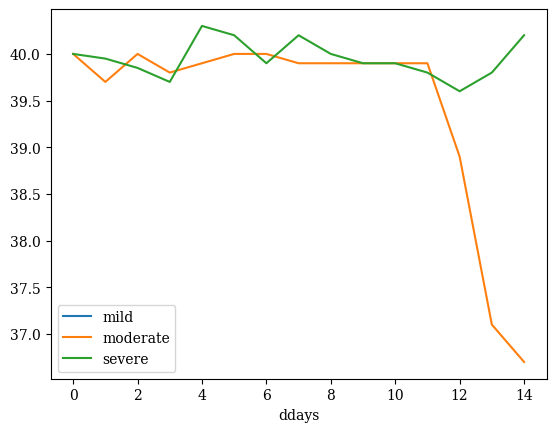

In [458]:
category = ['mild', 'moderate', 'severe']
measurement = 'Body temperature'

median_temps = pd.DataFrame(range(15), columns = ['ddays'])

for cat in category:
    median_temps[cat] = get_stats(person_data, cat,measurement)['median']
    
print(median_temps)
median_temps.plot(x = 'ddays', y = category)

In [652]:

def plot_data(ax, median_sbp, title, xlabel, ylabel, cat1_label, cat2_label):
    



    # Plot moderate category with customized hex colors
    ax.errorbar(median_sbp['ddays'], median_sbp['moderate_median'], yerr=median_sbp['moderate_iqr'], 
                label=cat1_label, color='#4169E1', fmt='-o', capsize=7, capthick=2, errorevery=1, 
                ecolor='#aec7e8', elinewidth=8, alpha=0.75, linewidth=2, markersize=8)

    # Plot severe category with customized hex colors
    ax.errorbar(median_sbp['ddays'], median_sbp['severe_median'], yerr=median_sbp['severe_iqr'], 
                label=cat2_label, color='#EE6745', fmt='-^', capsize=7, capthick=2, errorevery=1, 
                ecolor='#f2bcae', elinewidth=8, alpha=0.75, linewidth=2, markersize=8)


    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_facecolor('whitesmoke')
    

    


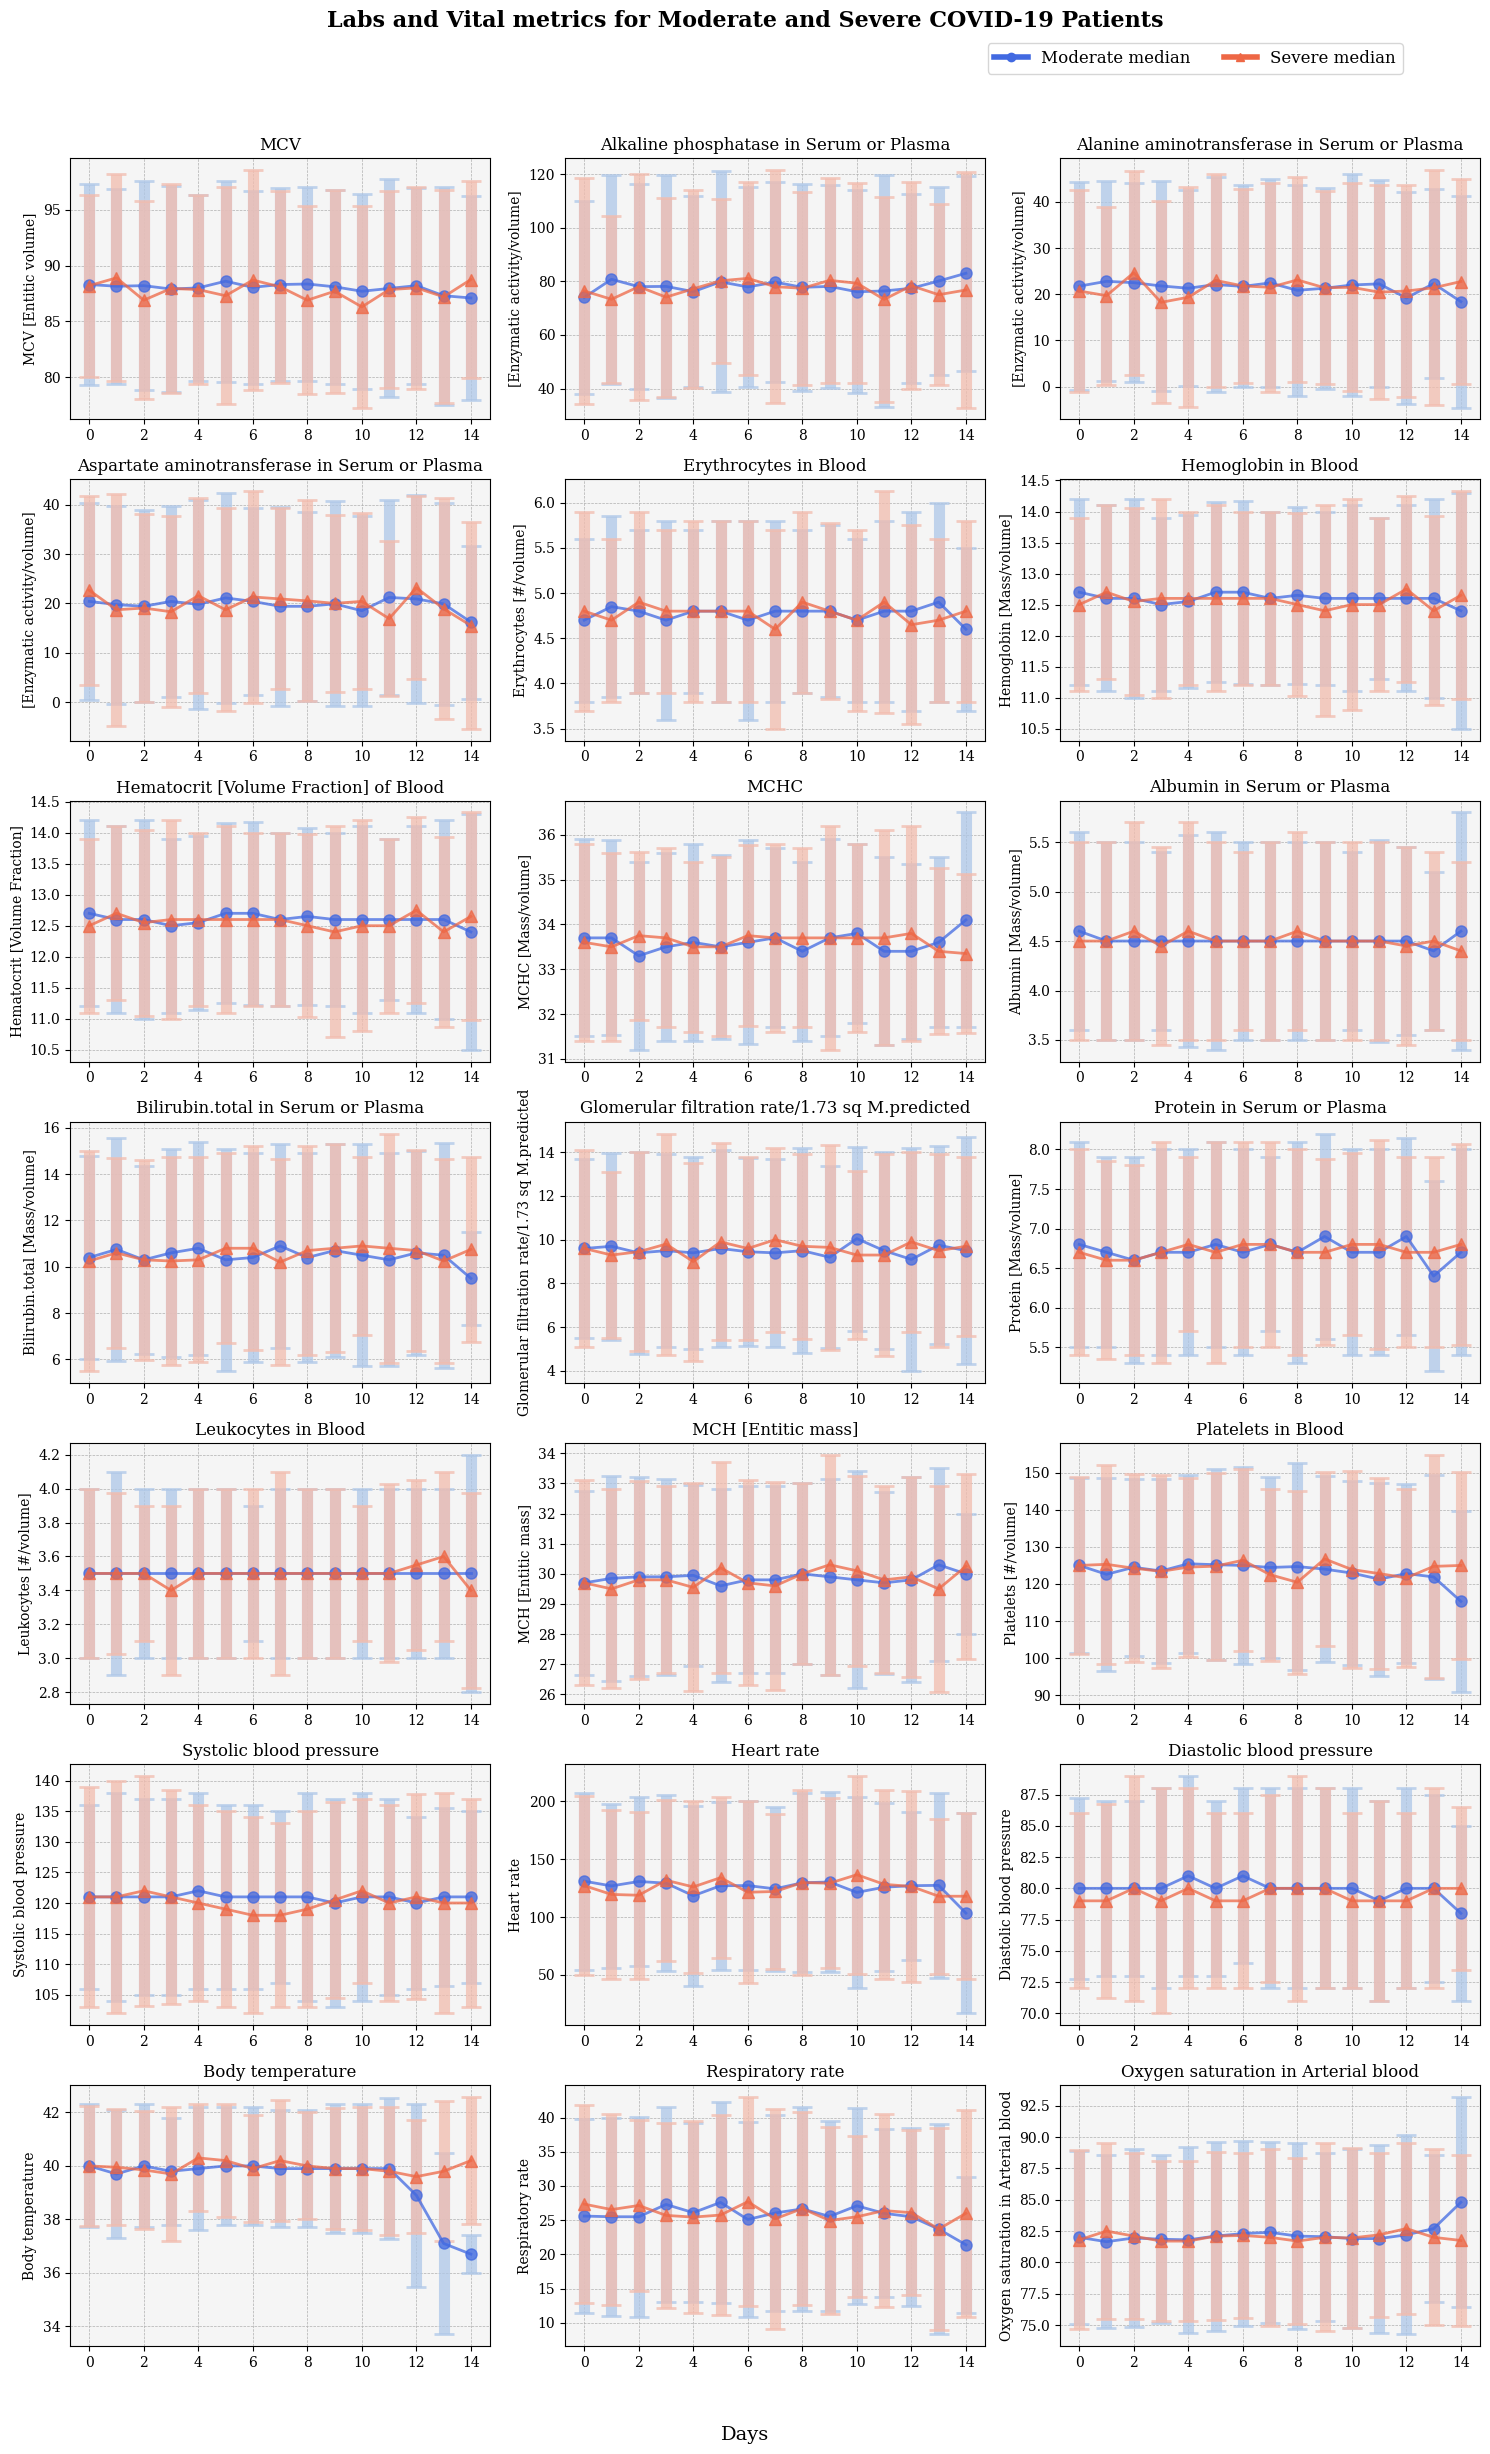

In [597]:


category = ['moderate', 'severe']

fig = plt.figure(figsize=(15, 25))
# Create a GridSpec of 5 rows and 3 columns
gs = gridspec.GridSpec(7, 3, figure=fig)

# First position for the heart rate plot
ax0 = fig.add_subplot(gs[0, 0])
# Insert your heart rate plotting code here
measurement = 'MCV [Entitic volume] by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement)


# Call the new plot function
plot_data(ax0, median_sbp, 'MCV', 'Days', 
          'MCV [Entitic volume]', 'Moderate median', 'Severe median')



#####
# Second position 
ax1 = fig.add_subplot(gs[0, 1])
# Insert your heart rate plotting code here
measurement1 = 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement1)


# Call the new plot function
plot_data(ax1, median_sbp, 'Alkaline phosphatase in Serum or Plasma', 'Days', 
          '[Enzymatic activity/volume]', 'Moderate median', 'Severe median')

#####

# third position 
ax2 = fig.add_subplot(gs[0, 2])
# Insert your heart rate plotting code here
measurement2 = 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement2)


# Call the new plot function
plot_data(ax2, median_sbp, 'Alanine aminotransferase in Serum or Plasma', 'Days', 
          '[Enzymatic activity/volume]', 'Moderate median', 'Severe median')
######

# fourth position 
ax3 = fig.add_subplot(gs[1, 0])
# Insert your heart rate plotting code here
measurement3 = 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement3)


# Call the new plot function
plot_data(ax3, median_sbp, 'Aspartate aminotransferase in Serum or Plasma', 'Days', 
          '[Enzymatic activity/volume]', 'Moderate median', 'Severe median')

######

# fifth position 
ax4 = fig.add_subplot(gs[1, 1])
# Insert your heart rate plotting code here
measurement4 = 'Erythrocytes [#/volume] in Blood by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement4)


# Call the new plot function
plot_data(ax4, median_sbp, 'Erythrocytes in Blood', 'Days', 
          'Erythrocytes [#/volume]', 'Moderate median', 'Severe median')


######

# sixth position 
ax5 = fig.add_subplot(gs[1, 2])
# Insert your heart rate plotting code here
measurement5 = 'Hemoglobin [Mass/volume] in Blood'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement5)


# Call the new plot function
plot_data(ax5, median_sbp, 'Hemoglobin in Blood', 'Days', 
          'Hemoglobin [Mass/volume]', 'Moderate median', 'Severe median')

######

# seventh position 
ax6 = fig.add_subplot(gs[2, 0])
# Insert your heart rate plotting code here
measurement6 = 'Hemoglobin [Mass/volume] in Blood'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement6)


# Call the new plot function
plot_data(ax6, median_sbp, 'Hematocrit [Volume Fraction] of Blood', 'Days', 
          'Hematocrit [Volume Fraction]', 'Moderate median', 'Severe median')

######
# eigth position 
ax7 = fig.add_subplot(gs[2, 1])
# Insert your heart rate plotting code here
measurement7 = 'MCHC [Mass/volume] by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement7)


# Call the new plot function
plot_data(ax7, median_sbp, 'MCHC', 'Days', 
          'MCHC [Mass/volume]', 'Moderate median', 'Severe median')

######
# ninth position 
ax8 = fig.add_subplot(gs[2, 2])
# Insert your heart rate plotting code here
measurement8 = 'Albumin [Mass/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement8)


# Call the new plot function
plot_data(ax8, median_sbp, 'Albumin in Serum or Plasma', 'Days', 
          'Albumin [Mass/volume]', 'Moderate median', 'Severe median')

######
# tenth position 
ax9 = fig.add_subplot(gs[3, 0])
# Insert your heart rate plotting code here
measurement9 = 'Bilirubin.total [Mass/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement9)


# Call the new plot function
plot_data(ax9, median_sbp, 'Bilirubin.total in Serum or Plasma', 'Days', 
          'Bilirubin.total [Mass/volume]', 'Moderate median', 'Severe median')

######
# eventh position 
ax10 = fig.add_subplot(gs[3, 1])
# Insert your heart rate plotting code here
measurement10 = 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement10)


# Call the new plot function
plot_data(ax10, median_sbp, 'Glomerular filtration rate/1.73 sq M.predicted', 'Days', 
          'Glomerular filtration rate/1.73 sq M.predicted', 'Moderate median', 'Severe median')

######
# 12th position 
ax11 = fig.add_subplot(gs[3, 2])
# Insert your heart rate plotting code here
measurement11 = 'Protein [Mass/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement11)


# Call the new plot function
plot_data(ax11, median_sbp, 'Protein in Serum or Plasma', 'Days', 
          'Protein [Mass/volume]', 'Moderate median', 'Severe median')

######
# 13th position 
ax12 = fig.add_subplot(gs[4, 0])
# Insert your heart rate plotting code here
measurement12 = 'Leukocytes [#/volume] in Blood by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement12)


# Call the new plot function
plot_data(ax12, median_sbp, 'Leukocytes in Blood', 'Days', 
          'Leukocytes [#/volume]', 'Moderate median', 'Severe median')

######
# 14th position 
ax13 = fig.add_subplot(gs[4, 1])
# Insert your heart rate plotting code here
measurement13 = 'MCH [Entitic mass] by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement13)


# Call the new plot function
plot_data(ax13, median_sbp, 'MCH [Entitic mass]', 'Days', 
          'MCH [Entitic mass]', 'Moderate median', 'Severe median')

######
# 15th position 
ax14 = fig.add_subplot(gs[4, 2])
# Insert your heart rate plotting code here
measurement14 = 'Platelets [#/volume] in Blood by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement14)


# Call the new plot function
plot_data(ax14, median_sbp, 'Platelets in Blood', 'Days', 
          'Platelets [#/volume]', 'Moderate median', 'Severe median')

######
# 16th position 
ax15 = fig.add_subplot(gs[5, 0])
# Insert your heart rate plotting code here
measurement15 = 'Systolic blood pressure'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement15)


# Call the new plot function
plot_data(ax15, median_sbp, 'Systolic blood pressure', 'Days', 
          'Systolic blood pressure', 'Moderate median', 'Severe median')

######
# 17th position 
ax16 = fig.add_subplot(gs[5, 1])
# Insert your heart rate plotting code here
measurement16 = 'Heart rate'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement16)


# Call the new plot function
plot_data(ax16, median_sbp, 'Heart rate', 'Days', 
          'Heart rate', 'Moderate median', 'Severe median')

######
# 18th position 
ax17 = fig.add_subplot(gs[5, 2])
# Insert your heart rate plotting code here
measurement17 = 'Diastolic blood pressure'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement17)


# Call the new plot function
plot_data(ax17, median_sbp, 'Diastolic blood pressure', 'Days', 
          'Diastolic blood pressure', 'Moderate median', 'Severe median')
          
######
# 19th position 
ax18 = fig.add_subplot(gs[6, 0])
# Insert your heart rate plotting code here
measurement18 = 'Body temperature'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement18)


# Call the new plot function
plot_data(ax18, median_sbp, 'Body temperature', 'Days', 
          'Body temperature', 'Moderate median', 'Severe median')

######
# 20th position 
ax19 = fig.add_subplot(gs[6, 1])
# Insert your heart rate plotting code here
measurement19 = 'Respiratory rate'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement19)


# Call the new plot function
plot_data(ax19, median_sbp, 'Respiratory rate', 'Days', 
          'Respiratory rate', 'Moderate median', 'Severe median')

######
# 21st position 
ax20 = fig.add_subplot(gs[6, 2])
# Insert your heart rate plotting code here
measurement20 = 'Oxygen saturation in Arterial blood'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement20)


# Call the new plot function
plot_data(ax20, median_sbp, 'Oxygen saturation in Arterial blood', 'Days', 
          'Oxygen saturation in Arterial blood', 'Moderate median', 'Severe median')


# Create a custom legend for the entire figure
from matplotlib.lines import Line2D  # Import necessary for custom legend

custom_lines = [Line2D([0], [0], color='#4169E1', lw=4, label='Moderate median', marker='o'),
                Line2D([0], [0], color='#EE6745', lw=4, label='Severe median', marker='^')]

# Place the legend on the figure. Adjust 'loc' and 'bbox_to_anchor' to position your legend
# 'bbox_to_anchor' values: (x, y, width, height)
fig.legend(handles=custom_lines, loc='upper center', bbox_to_anchor=(0.8, 0.97), ncol=2, fontsize=12)


fig.suptitle('Labs and Vital metrics for Moderate and Severe COVID-19 Patients', fontsize=16, fontweight='bold')

# Adjust the layout to make room for the common X-axis label
fig.subplots_adjust(bottom=0.04)  # Adjust this as needed based on your figure

# Add a common X-axis label
fig.text(0.5, 0.01, 'Days', ha='center', va='center', fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameters as needed for your figure layout

plt.savefig('fig1')
plt.show()

In [ ]:
""""
eFigure 1: Trajectories of Vitals and Laboratory Tests for Moderate and Severe Patients

This figure shows the median (line) and interquartile range (bars) of each laboratory and vital test performed after COVID-19 diagnosis, stratified by
patient severity (moderate [blue] and severe[red]). Mild patient vitals and lab measurements are not included. The x-axis represents the days after the 
COVID-19 diagnosis when the lab or vital measurement was taken. 

""""

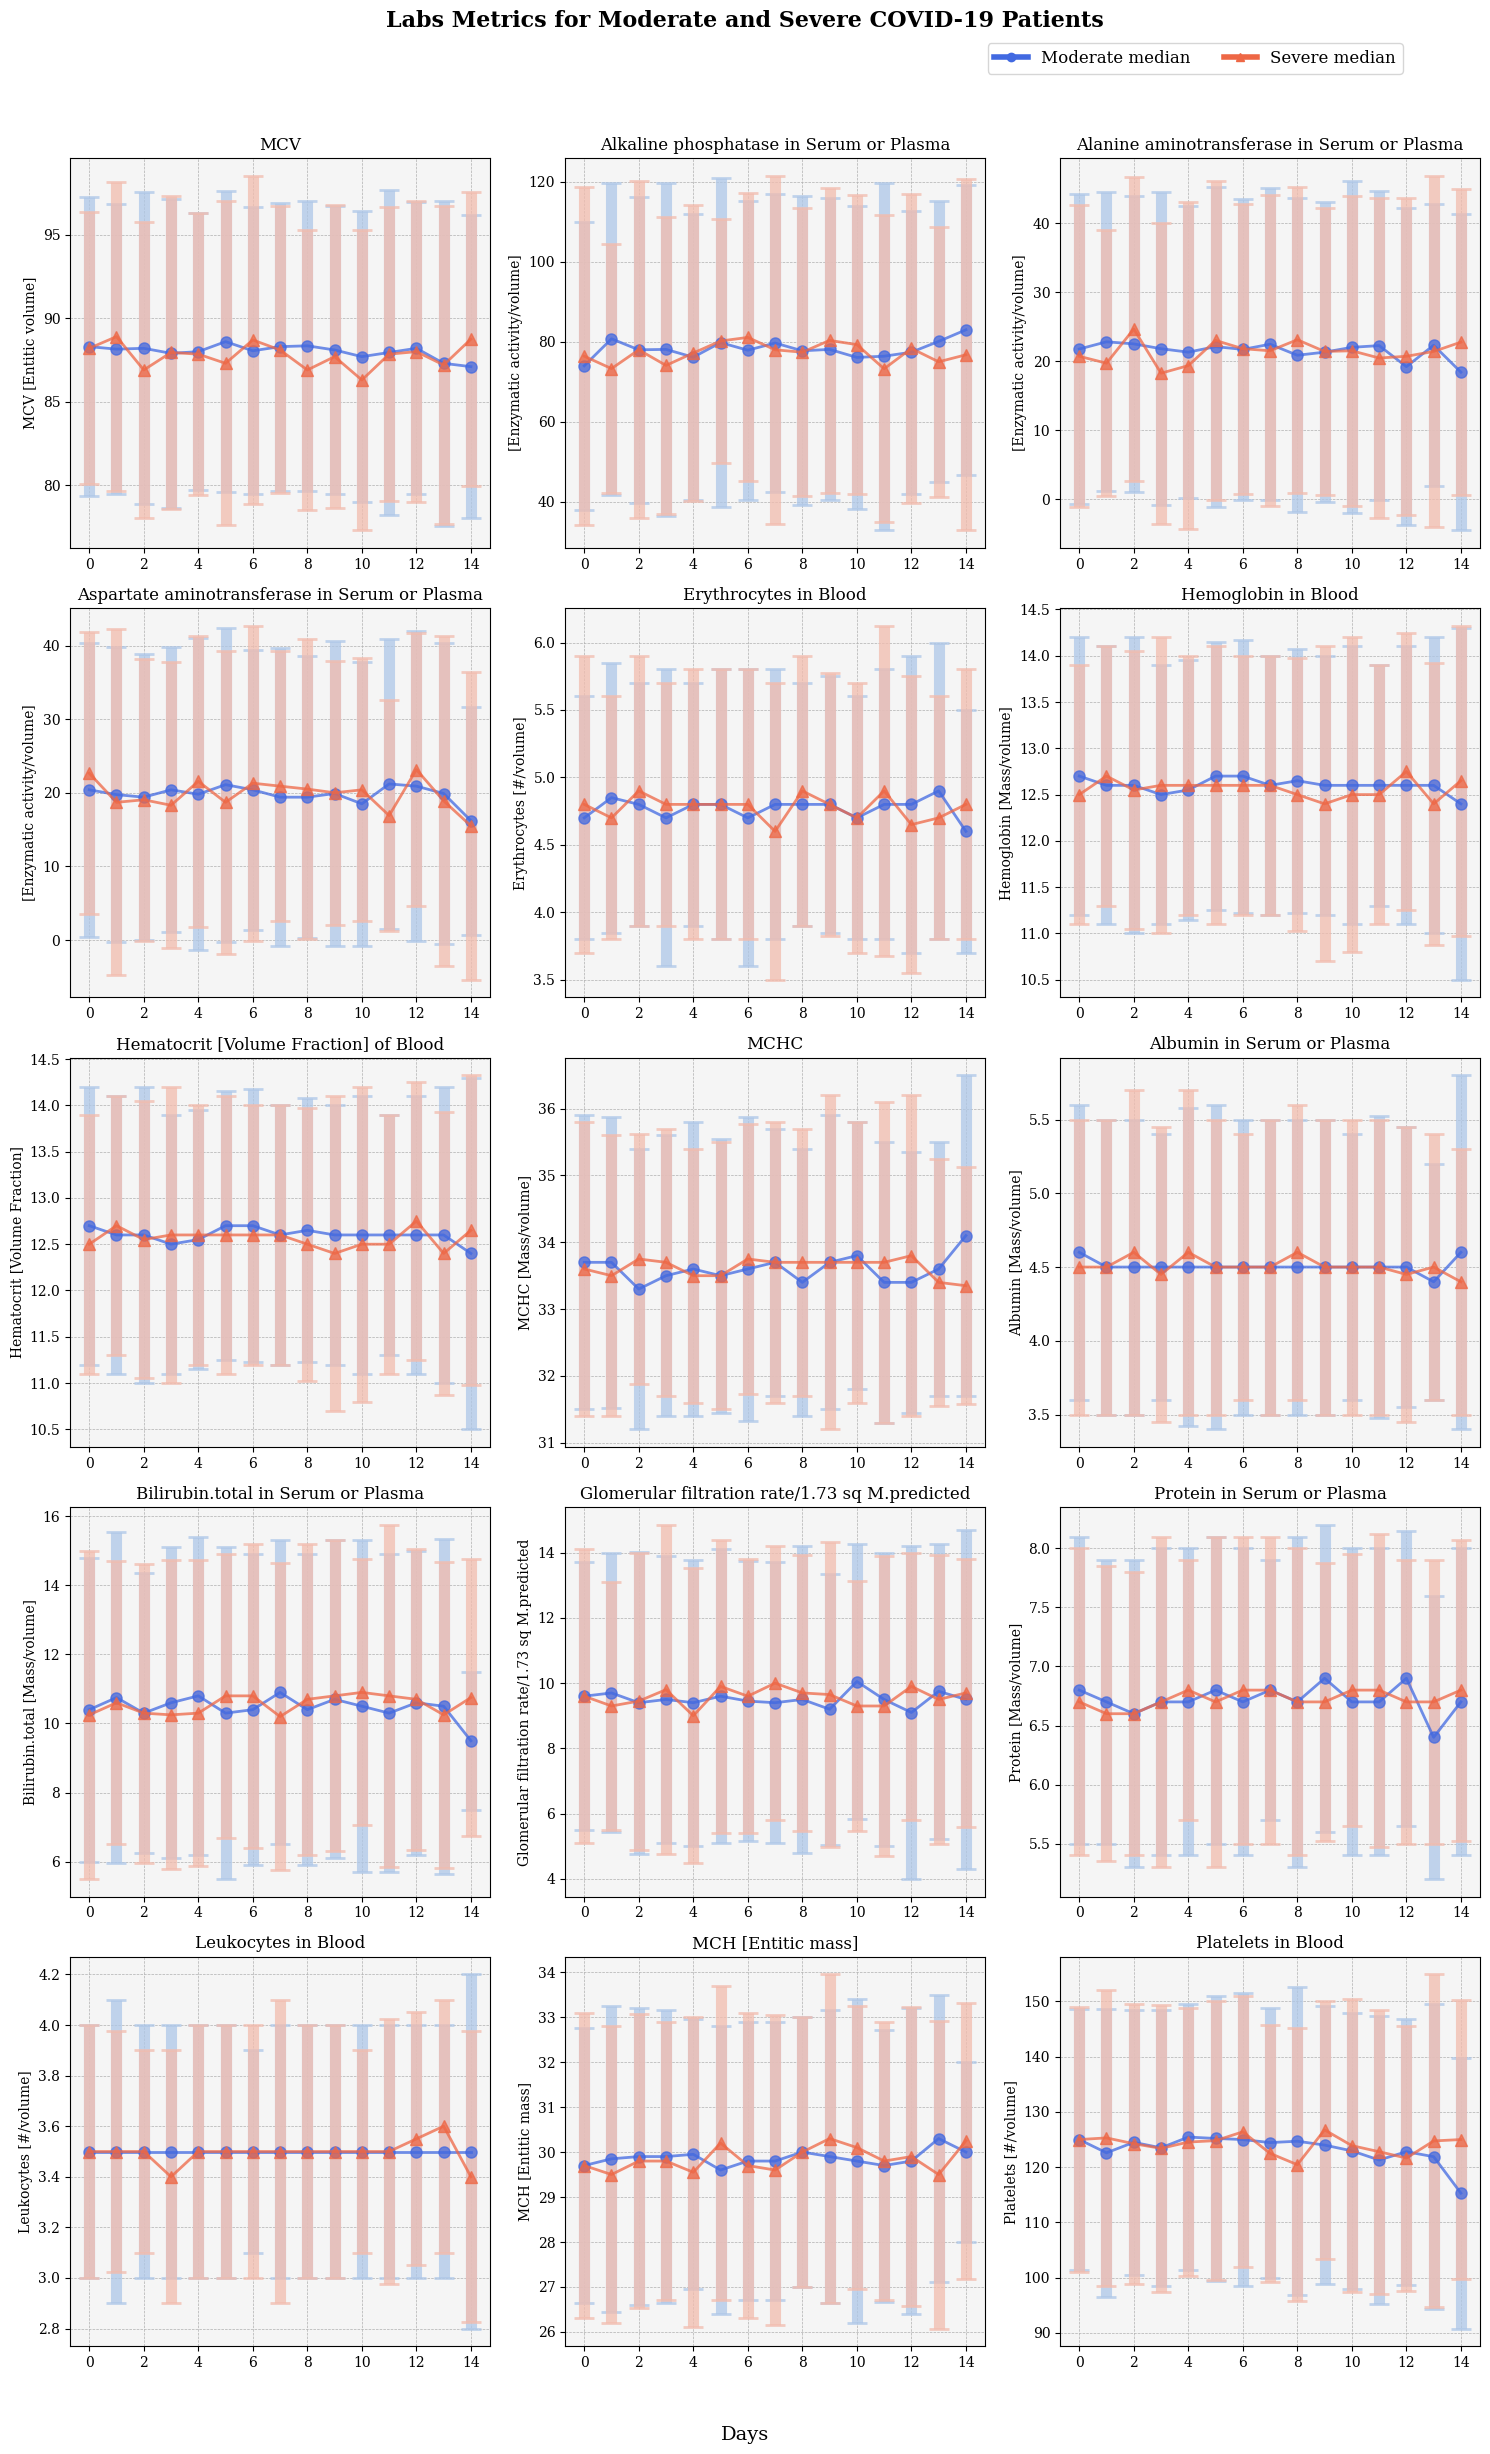

In [671]:

category = ['moderate', 'severe']

fig = plt.figure(figsize=(15, 25))
# Create a GridSpec of 5 rows and 3 columns
gs = gridspec.GridSpec(5, 3, figure=fig)

# First position for the heart rate plot
ax0 = fig.add_subplot(gs[0, 0])
# Insert your heart rate plotting code here
measurement = 'MCV [Entitic volume] by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement)


# Call the new plot function
plot_data(ax0, median_sbp, 'MCV', 'Days', 
          'MCV [Entitic volume]', 'Moderate median', 'Severe median')



#####
# Second position 
ax1 = fig.add_subplot(gs[0, 1])
# Insert your heart rate plotting code here
measurement1 = 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement1)


# Call the new plot function
plot_data(ax1, median_sbp, 'Alkaline phosphatase in Serum or Plasma', 'Days', 
          '[Enzymatic activity/volume]', 'Moderate median', 'Severe median')

#####

# third position 
ax2 = fig.add_subplot(gs[0, 2])
# Insert your heart rate plotting code here
measurement2 = 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement2)


# Call the new plot function
plot_data(ax2, median_sbp, 'Alanine aminotransferase in Serum or Plasma', 'Days', 
          '[Enzymatic activity/volume]', 'Moderate median', 'Severe median')
######

# fourth position 
ax3 = fig.add_subplot(gs[1, 0])
# Insert your heart rate plotting code here
measurement3 = 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement3)


# Call the new plot function
plot_data(ax3, median_sbp, 'Aspartate aminotransferase in Serum or Plasma', 'Days', 
          '[Enzymatic activity/volume]', 'Moderate median', 'Severe median')

######

# fifth position 
ax4 = fig.add_subplot(gs[1, 1])
# Insert your heart rate plotting code here
measurement4 = 'Erythrocytes [#/volume] in Blood by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement4)


# Call the new plot function
plot_data(ax4, median_sbp, 'Erythrocytes in Blood', 'Days', 
          'Erythrocytes [#/volume]', 'Moderate median', 'Severe median')


######

# sixth position 
ax5 = fig.add_subplot(gs[1, 2])
# Insert your heart rate plotting code here
measurement5 = 'Hemoglobin [Mass/volume] in Blood'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement5)


# Call the new plot function
plot_data(ax5, median_sbp, 'Hemoglobin in Blood', 'Days', 
          'Hemoglobin [Mass/volume]', 'Moderate median', 'Severe median')

######

# seventh position 
ax6 = fig.add_subplot(gs[2, 0])
# Insert your heart rate plotting code here
measurement6 = 'Hemoglobin [Mass/volume] in Blood'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement6)


# Call the new plot function
plot_data(ax6, median_sbp, 'Hematocrit [Volume Fraction] of Blood', 'Days', 
          'Hematocrit [Volume Fraction]', 'Moderate median', 'Severe median')

######
# eigth position 
ax7 = fig.add_subplot(gs[2, 1])
# Insert your heart rate plotting code here
measurement7 = 'MCHC [Mass/volume] by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement7)


# Call the new plot function
plot_data(ax7, median_sbp, 'MCHC', 'Days', 
          'MCHC [Mass/volume]', 'Moderate median', 'Severe median')

######
# ninth position 
ax8 = fig.add_subplot(gs[2, 2])
# Insert your heart rate plotting code here
measurement8 = 'Albumin [Mass/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement8)


# Call the new plot function
plot_data(ax8, median_sbp, 'Albumin in Serum or Plasma', 'Days', 
          'Albumin [Mass/volume]', 'Moderate median', 'Severe median')

######
# tenth position 
ax9 = fig.add_subplot(gs[3, 0])
# Insert your heart rate plotting code here
measurement9 = 'Bilirubin.total [Mass/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement9)


# Call the new plot function
plot_data(ax9, median_sbp, 'Bilirubin.total in Serum or Plasma', 'Days', 
          'Bilirubin.total [Mass/volume]', 'Moderate median', 'Severe median')

######
# eventh position 
ax10 = fig.add_subplot(gs[3, 1])
# Insert your heart rate plotting code here
measurement10 = 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement10)


# Call the new plot function
plot_data(ax10, median_sbp, 'Glomerular filtration rate/1.73 sq M.predicted', 'Days', 
          'Glomerular filtration rate/1.73 sq M.predicted', 'Moderate median', 'Severe median')

######
# 12th position 
ax11 = fig.add_subplot(gs[3, 2])
# Insert your heart rate plotting code here
measurement11 = 'Protein [Mass/volume] in Serum or Plasma'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement11)


# Call the new plot function
plot_data(ax11, median_sbp, 'Protein in Serum or Plasma', 'Days', 
          'Protein [Mass/volume]', 'Moderate median', 'Severe median')

######
# 13th position 
ax12 = fig.add_subplot(gs[4, 0])
# Insert your heart rate plotting code here
measurement12 = 'Leukocytes [#/volume] in Blood by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement12)


# Call the new plot function
plot_data(ax12, median_sbp, 'Leukocytes in Blood', 'Days', 
          'Leukocytes [#/volume]', 'Moderate median', 'Severe median')

######
# 14th position 
ax13 = fig.add_subplot(gs[4, 1])
# Insert your heart rate plotting code here
measurement13 = 'MCH [Entitic mass] by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement13)


# Call the new plot function
plot_data(ax13, median_sbp, 'MCH [Entitic mass]', 'Days', 
          'MCH [Entitic mass]', 'Moderate median', 'Severe median')

######
# 15th position 
ax14 = fig.add_subplot(gs[4, 2])
# Insert your heart rate plotting code here
measurement14 = 'Platelets [#/volume] in Blood by Automated count'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement14)


# Call the new plot function
plot_data(ax14, median_sbp, 'Platelets in Blood', 'Days', 
          'Platelets [#/volume]', 'Moderate median', 'Severe median')



# Create a custom legend for the entire figure
from matplotlib.lines import Line2D  # Import necessary for custom legend

custom_lines = [Line2D([0], [0], color='#4169E1', lw=4, label='Moderate median', marker='o'),
                Line2D([0], [0], color='#EE6745', lw=4, label='Severe median', marker='^')]

# Place the legend on the figure. Adjust 'loc' and 'bbox_to_anchor' to position your legend
# 'bbox_to_anchor' values: (x, y, width, height)
fig.legend(handles=custom_lines, loc='upper center', bbox_to_anchor=(0.8, 0.97), ncol=2, fontsize=12)


fig.suptitle('Labs Metrics for Moderate and Severe COVID-19 Patients', fontsize=16, fontweight='bold')

# Adjust the layout to make room for the common X-axis label
fig.subplots_adjust(bottom=0.04)  # Adjust this as needed based on your figure

# Add a common X-axis label
fig.text(0.5, 0.01, 'Days', ha='center', va='center', fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameters as needed for your figure layout

plt.savefig('fig1')
plt.show()

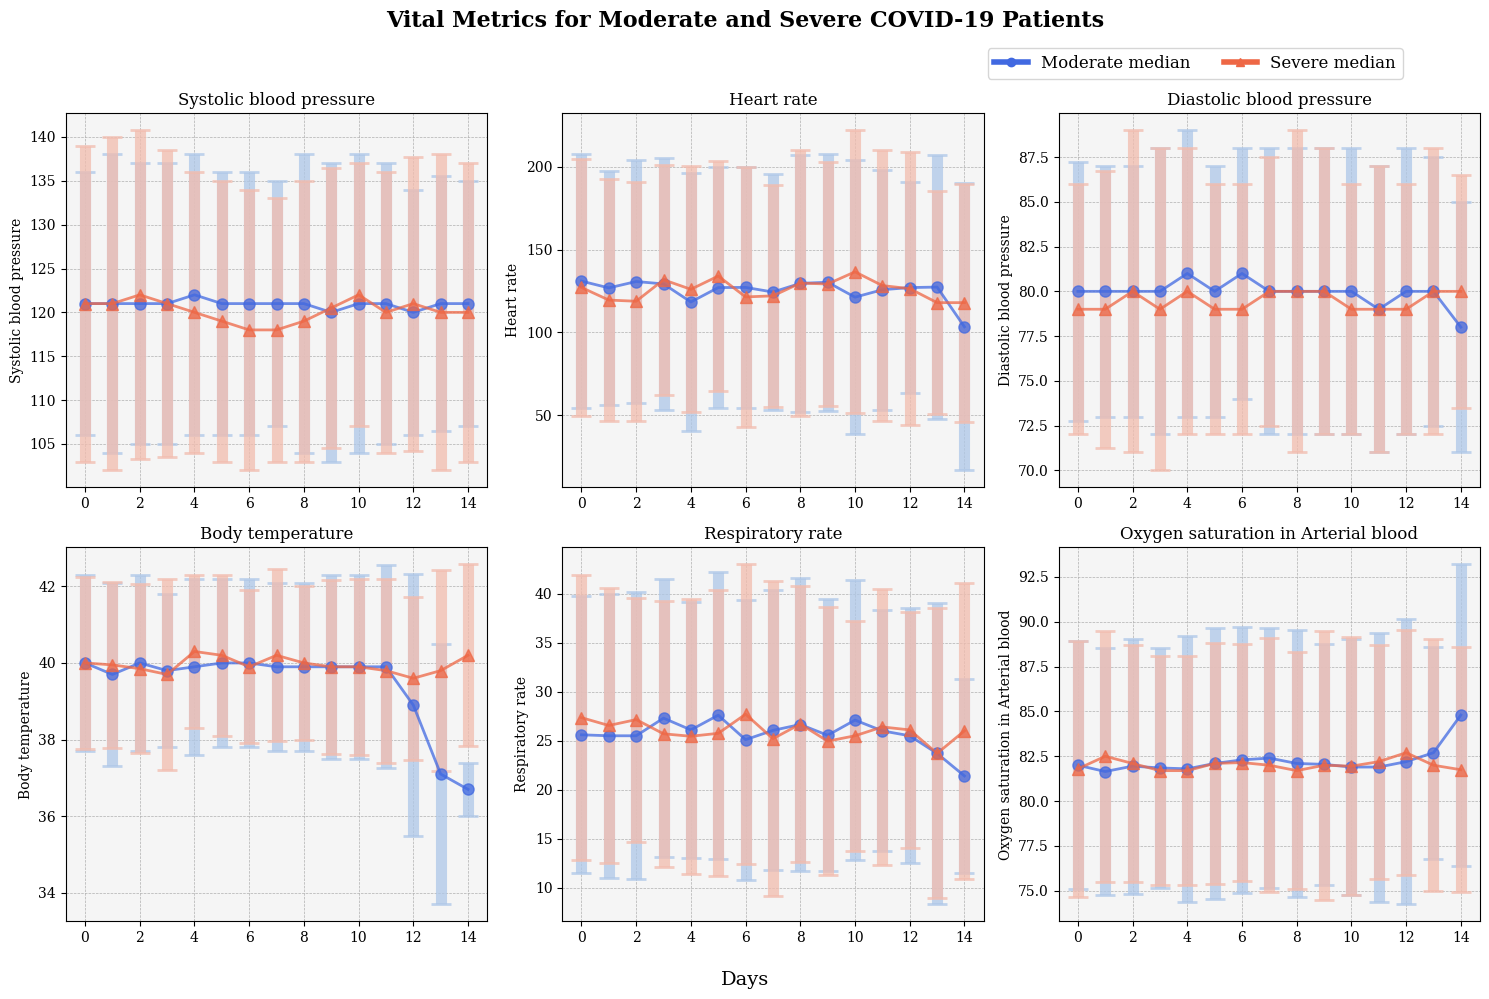

In [672]:

category = ['moderate', 'severe']

fig = plt.figure(figsize=(15, 10))
# Create a GridSpec of 5 rows and 3 columns
gs = gridspec.GridSpec(2, 3, figure=fig)

######
# 16th position 
ax15 = fig.add_subplot(gs[0, 0])
# Insert your heart rate plotting code here
measurement15 = 'Systolic blood pressure'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement15)


# Call the new plot function
plot_data(ax15, median_sbp, 'Systolic blood pressure', 'Days', 
          'Systolic blood pressure', 'Moderate median', 'Severe median')

######
# 17th position 
ax16 = fig.add_subplot(gs[0, 1])
# Insert your heart rate plotting code here
measurement16 = 'Heart rate'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement16)


# Call the new plot function
plot_data(ax16, median_sbp, 'Heart rate', 'Days', 
          'Heart rate', 'Moderate median', 'Severe median')

######
# 18th position 
ax17 = fig.add_subplot(gs[0, 2])
# Insert your heart rate plotting code here
measurement17 = 'Diastolic blood pressure'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement17)


# Call the new plot function
plot_data(ax17, median_sbp, 'Diastolic blood pressure', 'Days', 
          'Diastolic blood pressure', 'Moderate median', 'Severe median')
          
######
# 19th position 
ax18 = fig.add_subplot(gs[1, 0])
# Insert your heart rate plotting code here
measurement18 = 'Body temperature'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement18)


# Call the new plot function
plot_data(ax18, median_sbp, 'Body temperature', 'Days', 
          'Body temperature', 'Moderate median', 'Severe median')

######
# 20th position 
ax19 = fig.add_subplot(gs[1, 1])
# Insert your heart rate plotting code here
measurement19 = 'Respiratory rate'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement19)


# Call the new plot function
plot_data(ax19, median_sbp, 'Respiratory rate', 'Days', 
          'Respiratory rate', 'Moderate median', 'Severe median')

######
# 21st position 
ax20 = fig.add_subplot(gs[1, 2])
# Insert your heart rate plotting code here
measurement20 = 'Oxygen saturation in Arterial blood'

# Process stats (assuming process_stats function is defined as shown previously)
median_sbp = process_stats(person_data, category, measurement20)


# Call the new plot function
plot_data(ax20, median_sbp, 'Oxygen saturation in Arterial blood', 'Days', 
          'Oxygen saturation in Arterial blood', 'Moderate median', 'Severe median')

# Create a custom legend for the entire figure
from matplotlib.lines import Line2D  # Import necessary for custom legend

custom_lines = [Line2D([0], [0], color='#4169E1', lw=4, label='Moderate median', marker='o'),
                Line2D([0], [0], color='#EE6745', lw=4, label='Severe median', marker='^')]

# Place the legend on the figure. Adjust 'loc' and 'bbox_to_anchor' to position your legend
# 'bbox_to_anchor' values: (x, y, width, height)
fig.legend(handles=custom_lines, loc='upper center', bbox_to_anchor=(0.8, 0.95), ncol=2, fontsize=12)


fig.suptitle('Vital Metrics for Moderate and Severe COVID-19 Patients', fontsize=16, fontweight='bold')

# Adjust the layout to make room for the common X-axis label
fig.subplots_adjust(bottom=0.04)  # Adjust this as needed based on your figure

# Add a common X-axis label
fig.text(0.5, 0.01, 'Days', ha='center', va='center', fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameters as needed for your figure layout

plt.savefig('fig2')
plt.show()


In [595]:


def plot_measurement_violin(ax, person_data, measurement_name):
    custom_colors = {
        'mild': '#98DBC6', 
        'moderate': '#4169E1', 
        'severe': '#EE6745'  
    }
    
    # Filter the DataFrame to only include specified measurements 
    measurement_data = person_data[(person_data['measurement_name'] == measurement_name)]

    # Create the violin plot 
    sns.violinplot(ax=ax, x='category', y='value_as_number', data=measurement_data, palette=custom_colors)

    ax.set_title(f'{measurement_name}')
    ax.set_ylabel(f'{measurement_name}')
    ax.set_facecolor('whitesmoke')
    ax.grid(True)


In [584]:
person_data.head()

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,ddays
0,5,2020-03-10,mild,White,FEMALE,35.0,Body temperature,2020-03-10,41.6,degree Celsius,18-45,0
1,5,2020-03-10,mild,White,FEMALE,35.0,Respiratory rate,2020-03-10,14.4,per minute,18-45,0
2,5,2020-03-10,mild,White,FEMALE,35.0,Oxygen saturation in Arterial blood,2020-03-10,88.4,percent,18-45,0
3,5,2020-03-10,mild,White,FEMALE,35.0,Systolic blood pressure,2020-03-10,130.0,millimeter mercury column,18-45,0
4,5,2020-03-10,mild,White,FEMALE,35.0,Body weight,2020-03-10,74.4,kilogram,18-45,0


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

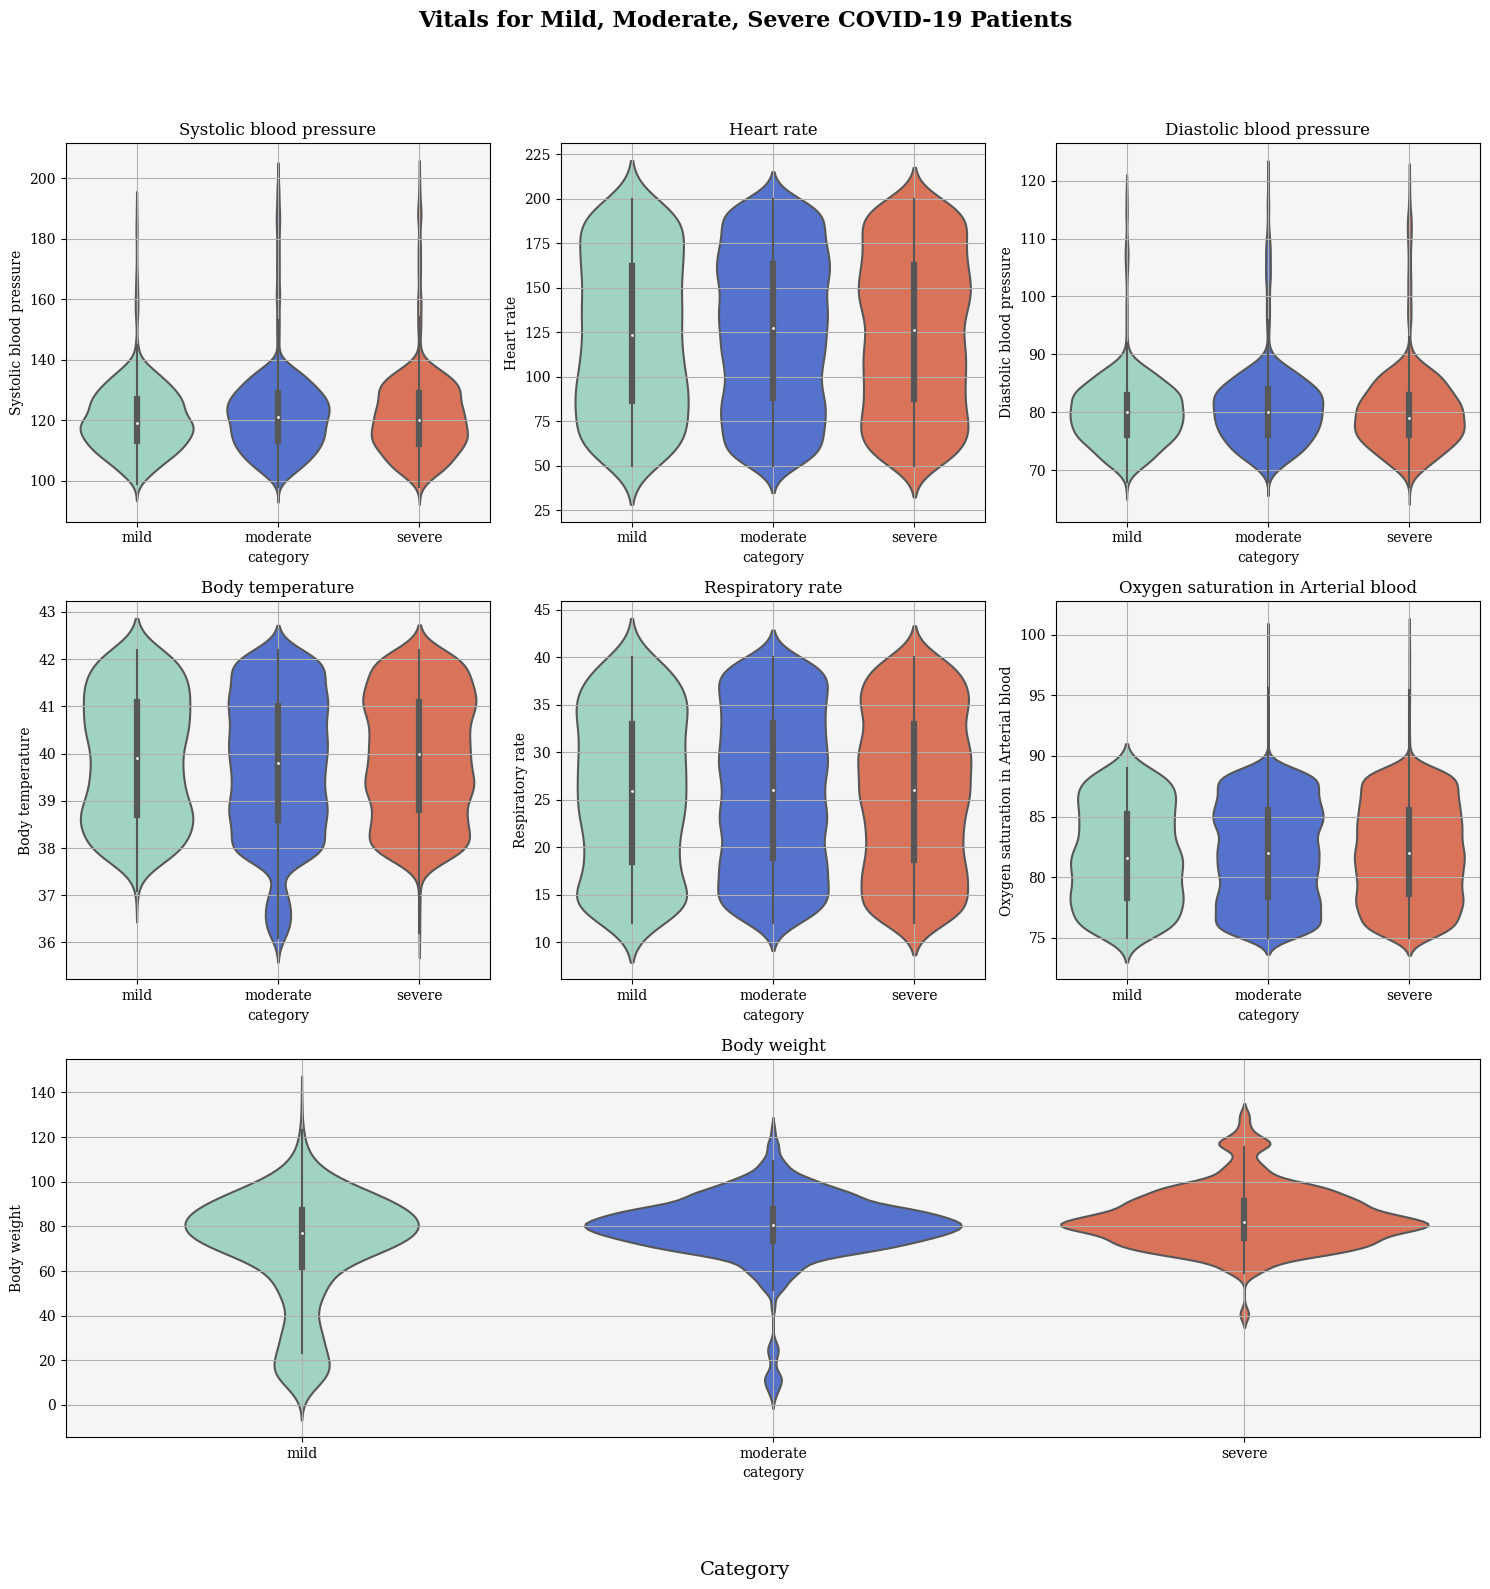

In [598]:
# Set up the figure and GridSpec
fig = plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(4, 3, figure=fig)

# First row of plots
ax1 = fig.add_subplot(gs[0, 0])
plot_measurement_violin(ax1, person_data,'Systolic blood pressure')

ax2 = fig.add_subplot(gs[0, 1])
plot_measurement_violin(ax2, person_data,'Heart rate')

ax3 = fig.add_subplot(gs[0, 2])
plot_measurement_violin(ax3, person_data,'Diastolic blood pressure')


# Second row of plots
ax4 = fig.add_subplot(gs[1, 0])
plot_measurement_violin(ax4, person_data,'Body temperature')

ax5 = fig.add_subplot(gs[1, 1])
plot_measurement_violin(ax5, person_data,'Respiratory rate')

ax6 = fig.add_subplot(gs[1, 2])
plot_measurement_violin(ax6, person_data,'Oxygen saturation in Arterial blood')



# Fourth row - the seventh plot spans all columns
ax7 = fig.add_subplot(gs[2, :])  # Span all columns in the fourth row
plot_measurement_violin(ax7, person_data,'Body weight')


fig.suptitle('Vitals for Mild, Moderate, Severe COVID-19 Patients', fontsize=16, fontweight='bold')



# Add a common X-axis label
fig.text(0.5, 0.2, 'Category', ha='center', va='center', fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameters as needed for your figure layout

plt.savefig('fig2')
plt.show()

## Look into why the "mild" systolic blood pressure jumps around so much

In [167]:
get_stats(person_data, 'mild', 'Systolic blood pressure')

,max,min,mean,median,count
ddays,,,,,
0,198.0,100.0,120.969349,120.0,1044
1,127.0,123.0,125.666667,127.0,3
2,115.0,109.0,112.000000,112.0,2
3,132.0,103.0,118.571429,121.0,7
4,129.0,129.0,129.000000,129.0,1
5,126.0,109.0,117.000000,115.0,5
6,116.0,105.0,110.500000,110.5,4
7,129.0,111.0,118.250000,116.5,4
8,122.0,105.0,113.000000,112.0,3


In [168]:
get_stats(person_data, 'moderate', 'Systolic blood pressure')

,max,min,mean,median,count
ddays,,,,,
0,199.0,101.0,122.730975,121.0,933
1,199.0,101.0,122.871245,121.0,466
2,198.0,100.0,122.892473,120.0,465
3,197.0,100.0,122.634989,120.0,463
4,197.0,97.0,122.377970,121.0,463
5,196.0,100.0,122.428879,121.0,464
6,194.0,99.0,122.430131,120.0,458
7,197.0,101.0,122.638528,120.0,462
8,198.0,98.0,122.659529,121.0,467


In [169]:
get_stats(person_data, 'severe', 'Systolic blood pressure')

,max,min,mean,median,count
ddays,,,,,
0,187.0,99.0,120.632603,119.0,411
1,181.0,100.0,121.648780,120.0,205
2,194.0,100.0,122.294686,120.0,207
3,194.0,100.0,122.153846,119.0,208
4,195.0,99.0,121.766234,119.0,231
5,197.0,101.0,122.411290,120.0,248
6,192.0,100.0,122.634855,121.0,241
7,187.0,102.0,122.593074,122.0,231
8,190.0,100.0,123.119342,122.0,243


In [170]:
day_1_data = person_data[person_data['ddays'] == 0]
print(len(day_1_data))
day_1_data.head()

27207


,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,age_groups,ddays
0,7,2020-03-09,mild,Black or African American,FEMALE,65.0,Body temperature,2020-03-09,39.2,degree Celsius,46-65,0
1,7,2020-03-09,mild,Black or African American,FEMALE,65.0,Respiratory rate,2020-03-09,31.3,per minute,46-65,0
2,7,2020-03-09,mild,Black or African American,FEMALE,65.0,Oxygen saturation in Arterial blood,2020-03-09,78.7,percent,46-65,0
3,7,2020-03-09,mild,Black or African American,FEMALE,65.0,Systolic blood pressure,2020-03-09,126.0,millimeter mercury column,46-65,0
4,7,2020-03-09,mild,Black or African American,FEMALE,65.0,Body weight,2020-03-09,81.2,kilogram,46-65,0
